<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/GaryBranch/Gary_of_A1_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [80]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec


%matplotlib inline
import matplotlib.pyplot as plt

import math
import bisect
from scipy.stats import zscore
from scipy.io import arff
from importlib import reload

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor

np.random.seed(1234)

# Data Handling

## Importing

In [81]:
### importing the files from the web to google colab

# hepatitis.data
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data

# messidor_features.arff
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff

--2022-10-06 17:41:36--  http://archive.ics.uci.edu/ml/machine-learning-databases/hepatitis/hepatitis.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7545 (7.4K) [application/x-httpd-php]
Saving to: ‘hepatitis.data.3’

hepatitis.data.3    100%[===================>]   7.37K  --.-KB/s    in 0s      

2022-10-06 17:41:36 (441 MB/s) - ‘hepatitis.data.3’ saved [7545/7545]

--2022-10-06 17:41:36--  https://archive.ics.uci.edu/ml/machine-learning-databases/00329/messidor_features.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117224 (114K) [application/x-httpd-php]
Saving to: ‘messidor_features.arff.3’

messidor_features.a 100%[===================>] 114.4

## Preprocessing

### Helper functions

In [82]:
# normalizes an input array
def normalize_array(arr):
  normalized_array = []

  for i in arr:
    new_val = (i - min(arr)) / (max(arr) - min(arr))
    normalized_array.append(new_val)

  return normalized_array

# normalizes columns in input dataframe df; 
# assumes last column is the target labels
def normalize_df(df):
  normalized_df = df.copy()

  for col in df.iloc[:, :-1]:
    normalized_col = normalize_array(df[col])
    normalized_df[col] = normalized_col

  return normalized_df

In [83]:
# standardizes columns in input dataframe df;
# assumes last column is the target labels


def standardize_df(df):
  standardized_df = df.copy()

  # iterates through each column, excluding the last column
  for col in df.iloc[:, :-1]:

    # calculates mean value and standard deviation of column
    mean_val = df[col].mean()
    standard_dev = df[col].std()

    # standardizes the values in the current column
    standardized_df[col] = (df[col] - mean_val) / standard_dev

  return standardized_df

In [101]:
# counts items in a given range
def count_in_ranges(item_arr, range_arr, bins = 10):

  count_arr = np.zeros(len(range_arr))

  for item in item_arr:
    pos = bisect.bisect_left(range_arr, item)
    count_arr[pos] += 1

  return count_arr

# creates histograms for each column in input dataframe df and array of columns
# column_arr
def create_histograms_non_bool_col(df, column_arr = 0):
  # if no array of column names given, creates histograms for all columns
  
  if column_arr == 0:
    column_arr = list(df)

  #setting up figure
  fig = plt.figure(figsize = (12,8), tight_layout=True) 

  #setting space for our gs. In this case it is a 2x3 grid
  #think of this as the whole space we have to put the plots in
  gs = gridspec.GridSpec(2,3)

  i=0
  j=0

  # iterates through each column name
  for col in column_arr:

    min = math.floor(df[col].min())
    max = math.ceil(df[col].max())
    mean = df[col].mean()
    
    range_arr = np.linspace(min, max + 1, 100)
    count_arr = count_in_ranges(df[col].to_numpy(), range_arr)

    if j==3:
      j=0
      i=i+1

    # plots histogram

    ax = fig.add_subplot(gs[i,j])
    ax.autoscale(True)
    ax.bar(count_arr, range_arr)
    ax.set_title(col.upper())
    ax.set_xlabel("Occurrence count")
    ax.set_ylabel("Value")
    ax.axhline(y = mean, color = 'r', linestyle = '-', label = "Mean = " + str(round(mean, 2)))
    ax.legend(loc = "upper right") 
 
    j=j+1
  plt.show()

In [85]:
### function to split the data

# assumes the last column of the df is the target label
# assumes percentage_train is an integer out of 100
def train_test_split(df, percentage_train = 66):

  # shuffling the order of rows in the input dataframe
  df = df.sample(frac = 1, random_state = 1)

  # splits the input dataframe into arrays of instances and labels
  x, y = df.iloc[:, :-1].to_numpy(), df.iloc[:, -1].to_numpy()

  # the number of data points
  instance_count = x.shape[0]

  # the number of instances to be used in the training data
  train_count = int(instance_count * (percentage_train / 100))

  # splitting the data into training data and labels,
  # and testing data and labels
  x_train, y_train = x[:train_count], y[:train_count]
  x_test, y_test = x[train_count:], y[train_count:]

  return x_train, y_train, x_test, y_test

In [86]:
# random forest for feature importance on a regression problem;
# assumes the first column is target labels
def RF_find_features(df):
  # splitting the data in the input dataframe df
  x_train, y_train, x_test, y_test = train_test_split(df)

  # define the model
  model = RandomForestRegressor()

  # fit the model
  model.fit(x_train, y_train)

  # the value at index i is the feature importance of the
  # feature at column i in the dataframe
  importance_arr = model.feature_importances_

  # summarize feature importance
  for i in range(len(importance_arr)):
      print('Feature: %s, Score: %.5f' % (list(df.columns)[i], importance_arr[i]))

  return importance_arr

def plot_feature_importance(importance_arr):
  plt.bar([x for x in range(len(importance_arr))], importance_arr)
  plt.title("Feature importance")
  plt.xlabel("Feature index in data")
  plt.ylabel("Score")
  plt.show

In [87]:
### computes zcore to remove outlier data
def remove_outliers(df):
  abs_z_scores = np.abs(df.apply(zscore))

  # a boolean array that returns True at index i if the row
  # i in df does not contain any values with a zscore greater
  # than 3
  instance_bool_arr = (abs_z_scores < 3).all(axis = 1)
  return df[instance_bool_arr]

### Loading and cleaning hepatitis.data

In [88]:
### creating the dataframe for hepatitis.data

# creates a dataframe from the .data file
hep_df = pd.read_csv("hepatitis.data", sep=",", header=None)

# the column names
hep_cols = ['CLASS', 'AGE', 'SEX', 'STEROID','ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN',
            'PROTIME', 'HISTOLOGY']

# adds the column names to the dataframe
hep_df.columns = hep_cols

In [89]:
### creating lists to separate the names of columns containing
### boolean values vs the ones containing continuous values

bool_col = ['CLASS', 'SEX', 'STEROID', 'ANTIVIRALS', 'FATIGUE',
            'MALAISE', 'ANOREXIA', 'LIVER BIG', 'LIVER FIRM',
            'SPLEEN PALPABLE', 'SPIDERS', 'ASCITES', 'VARICES',
            'HISTOLOGY']

non_bool_col = ['AGE', 'BILIRUBIN', 'ALK PHOSPHATE', 'SGOT', 'ALBUMIN', 'PROTIME']

In [90]:
### cleaning hepatitis dataframe

# saves a copy of the dataframe without rows that include '?' values
intact_rows = hep_df[~hep_df.eq('?').any(axis=1)].astype('float')

# iterates through columns with boolean values
for col in bool_col:

  # replaces instances of 1.0 and 2.0 with the boolean integers 0 and 1
  intact_rows[col] = intact_rows[col].replace({1.0:0, 2.0:1})
  # calculates the mode of the current column (ignores '?')
  mode = int(intact_rows[col].mode()[0])

  # in the original dataframe, replaces each '?' with the column's mode
  hep_df[col] = hep_df[col].replace({'?': mode}).astype('int64')
  # in the original dataframe, replaces 1.0 and 2.0 with boolean ints 0 and 1
  hep_df[col] = hep_df[col].replace({1.0:0, 2.0:1})

# iterates through columns with non-boolean values
for col in non_bool_col:
  # calculates the mean of the current column (ignores '?')
  mean = intact_rows[col].mean()
  # in the original dataframe, replaces each '?' with the column's mean
  hep_df[col] = hep_df[col].replace({'?': mean}).astype('float')

hep_df = remove_outliers(hep_df)

# moves the target "CLASS" column to the end of the dataframe
class_col = hep_df.pop('CLASS')
hep_df['CLASS'] = class_col

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Analysis of Hepatitis data

In [92]:
### finding the most correlated features with CLASS column (target)

# creates correlation dataframe
correlation_df = hep_df.corr()

# isolates for the CLASS column of the correlation dataframe and removes
# the CLASS row
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'CLASS')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

,CLASS
ALBUMIN,0.464922
ASCITES,0.409313
SPIDERS,0.390570


In [93]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'CLASS')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

,CLASS
BILIRUBIN,-0.403335
HISTOLOGY,-0.354126
AGE,-0.208460


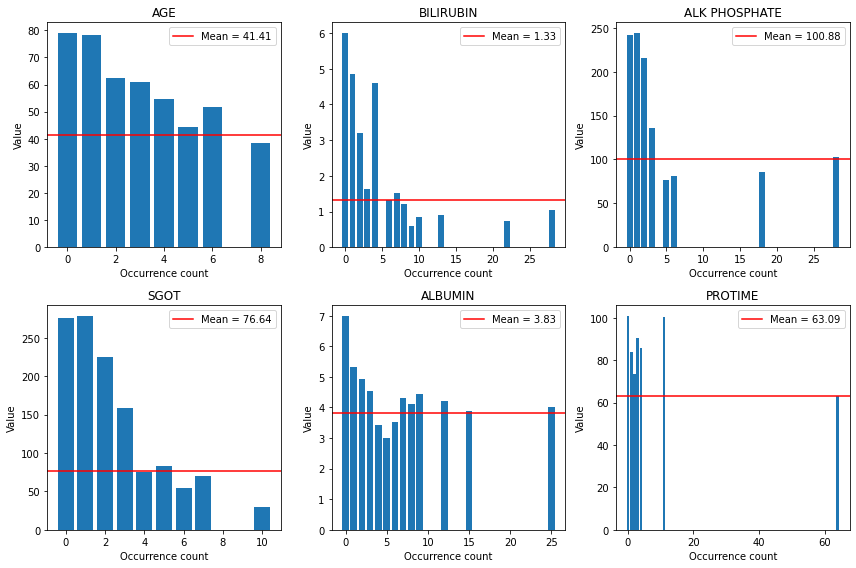

In [102]:
# histograms (but with occurrence count along the x-axis)
# of the non-boolean columns
create_histograms_non_bool_col(hep_df, non_bool_col)

In [ ]:
### using random forest to determine the relative feature importance

importance_arr = RF_find_features(hep_df)

# plots the feature importance
plot_feature_importance(importance_arr)

In [ ]:
### using random forest to determine the relative feature importance

importance_arr = RF_find_features(hep_df)

# plots the feature importance
plot_feature_importance(importance_arr)

In [ ]:
### finding the top 2 most important features to confirm values in correlation dataframe

top_feat_value = max(importance_arr)
top_feat_index = importance_arr.tolist().index(top_feat_value)

second_feat_value = np.max([val for index, val in enumerate(importance_arr) if index != top_feat_index])
second_feat_index = importance_arr.tolist().index(second_feat_value)

print("The most important feature is " + list(hep_df.columns)[top_feat_index])
print("The second most important feature is " + list(hep_df.columns)[second_feat_index])

In [ ]:
### analysis of boolean distributions

### Loading and cleaning messidor.arff

In [ ]:
### creating the dataframe for messidor_features.arff

# loads in the arff data
mess_data = arff.loadarff('messidor_features.arff')
# creates a dataframe from the .arff file
mess_df = pd.DataFrame(mess_data[0])

In [ ]:
### cleaning the data in mess_df

# columns with boolean values
bool_cols = ['0', '1', '18']

# ensures the columns with boolean values save as integers
for col in bool_cols:
  mess_df[col] = mess_df[col].astype('int64')

# resaving the boolean values in the Class column from objects to ints
mess_df['Class'] = mess_df['Class'].map({b'0':0, b'1':1}).astype('int64')

mess_df = remove_outliers(mess_df)

In [ ]:
mess_df

### Analysis of Messidor Features

In [ ]:
### finding the most correlated features with Class column (target)

# creates correlation dataframe
correlation_df = mess_df.corr()

# removes the first row of the correlation dataframe
class_correlation = (correlation_df).iloc[:-1, -1:]

# finds the 3 largest values (the 3 features most positively 
# correlated with CLASS)
pos_correlation = class_correlation.nlargest(3, 'Class')

# show the 3 features most positively correlated with target labels
pos_correlation.head()

In [ ]:
# finds the 3 smallest values (the 3 features most negatively
# correlated with CLASS)
neg_correlation = class_correlation.nsmallest(3, 'Class')

# show the 3 features most negatively correlated with target labels
neg_correlation.head()

In [ ]:
### creating histograms for each value

create_histograms(mess_df, list(mess_df)[2:18])

In [ ]:
### using random forest to determine the relative feature importance

importance_arr = RF_find_features(mess_df)

# plots the feature importance
plot_feature_importance(importance_arr)

In [ ]:
### finding the top 2 most important features to check values in correlation dataframe

top_feat_value = max(importance_arr)
top_feat_index = importance_arr.tolist().index(top_feat_value)

second_feat_value = np.max([val for index, val in enumerate(importance_arr) if index != top_feat_index])
second_feat_index = importance_arr.tolist().index(second_feat_value)

print("The most important feature is " + list(mess_df.columns)[top_feat_index])
print("The second most important feature is " + list(mess_df.columns)[second_feat_index])

# Implementing models

## Helper functions

In [ ]:
### accuracy-evaluating function
def evaluate_acc(true_labels, target_labels):

  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances
  # divided by the total amount
  accuracy = np.sum(target_labels == true_labels)/label_count

  return accuracy

## KNN

In [ ]:
# distance functions
euclidean = lambda x_train, x_test: np.sqrt(np.sum((x_train - x_test)**2, axis = -1))
manhattan = lambda x_train, x_test: np.sum(np.abs(x_train - x_test), axis = -1)
cosine = lambda x_train, x_test: np.sum(x_train * x_test, axis = -1) / ((np.sqrt(np.sum(x_train**2, axis = -1))) *(np.sqrt(np.sum(x_test**2, axis = -1))))

class KNN:
  # constructor
  def __init__(self, K = 1, dist_fn = euclidean):
    self.dist_fn = dist_fn
    self.K = K

  def fit(self, x_train, y_train):
    # stores the training data, since KNN is a lazy learner
    self.x_train = x_train
    self.y_train = y_train

    # the number of classes
    self.class_count = len(set(y_train))
    return self

  def predict(self, x_test):
    # uses the stored training data and x_test (test data passed as input)

    # the number of instances in the testing data
    instance_count = x_test.shape[0]

    # an array of the distances between the training data points and the testing
    # data points
    distances_arr = self.dist_fn(self.x_train[None, :, :], x_test[:, None, :])
    
    # initializes an array full of zeros for the k-nearest neighbours
    knn_arr = np.zeros((instance_count, self.K), dtype = int)
    # initializes an array full of zeros for the class probabilities
    class_prob = np.zeros((instance_count, self.class_count))

    # iterates through each instance in the testing data
    for instance in range(instance_count):
      # the i-th index is an array with the k-nearest neighbours in x_train to
      # data point i in x_test
      knn_arr[instance, :] = np.argsort(distances_arr[instance])[:self.K]
      
      # the i-th index is an array counting the occurrence of each
      # class type for data point i in x_test where the j-th index of the 
      # sub-array represents the number of neighbours in x_train of class j
      class_prob[instance, :] = np.bincount(self.y_train[knn_arr[instance,:]], minlength = self.class_count)
      #print(self.y_train[knn_arr[instance, :]].dtype)

    # divides all probabilities by the number of neighbours to look for
    class_prob /= self.K

    return class_prob, knn_arr


## Decision Tree

In [ ]:
class Node:
  def __init__(self, instance_indices, parent):

    # the indices of the instances (in the data) within this region of the DT
    self.instance_indices = instance_indices
    self.left = None
    self.right = None
    self.split_feature = None
    self.split_val = None

    # if the node has a parent
    if parent:
      self.depth = parent.depth + 1
      self.class_count = parent.class_count
      
      # pointer to original data
      self.data = parent.data
      self.labels = parent.labels
      class_prob = np.bincount(self.labels[instance_indices], minlength = self.class_count)
      self.class_prob = class_prob / np.sum(class_prob)

In [ ]:
def greedy_split(node, cost_fn):
  # if the split cannot be made, returns infinity
  best_cost = np.inf
  best_feature, best_value = None, None
  instance_count, feature_count = node.data.shape
  best_split = None

  # sorts the data within each column then saves boundary values in test_splits
  sorted_data = np.sort(node.data[node.instance_indices], axis = 0)
  test_splits = (sorted_data[1:] + sorted_data[:-1]) / 2

  for feature in range(feature_count):
    feature_data = node.data[node.instance_indices, feature]

    if(len(set(feature_data)) == 2):
      left_indices = node.instance_indices[feature_data == 0]
      right_indices = node.instance_indices[feature_data == 1]

    else:
      for split in test_splits[:, feature]:
        left_indices = node.instance_indices[feature_data <= split]
        right_indices = node.instance_indices[feature_data > split]

        if (len(left_indices) == 0) or (len(right_indices) == 0):
          continue

      left_cost = cost_fn(node.labels[left_indices])
      right_cost = cost_fn(node.labels[right_indices])

      left_count, right_count = left_indices.shape[0], right_indices.shape[0]
      cost = ((left_count * left_cost) + (right_count * right_cost)) / instance_count

      if cost < best_cost:
        best_cost = cost
        best_feature = feature
        best_split = split

  return best_cost, best_feature, best_split

In [ ]:
### cost functions

def misclassification_cost(labels):
  most_frequent_label = np.argmax(labels)
  cost = sum(1 for label in labels if label != most_frequent_label)
  return cost

def entropy_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for label in unique_labels:
    cur_labels = sum(1 for label in unique_labels)
    ratio = cur_labels / label_count
    cost += ratio * np.log2(ratio)

  cost *= -1
  return cost

def gini_cost(labels):
  cost = 0
  unique_labels = set(labels)
  label_count = len(labels)

  for label in unique_labels:
    cur_labels = sum(1 for label in unique_labels)
    ratio = cur_labels / label_count
    cost += np.square(ratio)

  cost = 1 - cost
  return cost

In [ ]:
### the tree stops splitting if
### 1) there are not enough points under the current node (min_instances)
### 2) maximum depth reached (max_depth)
### 3) decrease in cost is negligible

class DT:
  def __init__(self, class_count = None, max_depth = 3, cost_fn = entropy_cost, min_instances = 1):
    self.root = None
    self.max_depth = max_depth
    self.cost_fn = cost_fn
    self.class_count = class_count
    self.min_instances = min_instances

  def fit(self, data, labels):
    self.data = data
    self.labels = labels

    if self.class_count is None:
      self.class_count = len(set(labels))

    # root
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.class_count = self.class_count
    self.root.depth = 0

    # builds the rest of the tree
    self.fit_recursive(self.root)

    return self

  def fit_recursive(self, node):
    max_depth_reached = node.depth == self.max_depth
    insufficient_instances = len(node.instance_indices) <= self.min_instances

    # if the maximum depth was reached
    if max_depth_reached or insufficient_instances:
      return

    cost, split_feature, split_value = greedy_split(node, self.cost_fn)

    # it's not possible to split
    if np.isinf(cost):
      return

    left_split_indices = node.data[node.instance_indices, split_feature] <= split_value

    node.split_feature = split_feature
    node.split_value = split_value

    # new nodes
    new_left = Node(node.instance_indices[left_split_indices], node)
    new_right = Node(node.instance_indices[np.logical_not(left_split_indices)], node)

    # recursive call
    self.fit_recursive(new_left)
    self.fit_recursive(new_right)

    node.left = new_left
    node.right = new_right

  def predict(self, x_test):
    # initializing empty array
    class_probs = np.zeros((x_test.shape[0], self.class_count))

    for instance_num, instance_features in enumerate(x_test):
      node = self.root
      
      while node.left:
        if instance_features[node.split_feature] <= node.split_value:
          node = node.left
        else:
          node = node.right

      # while loop terminates when you reach a leaf of the tree
      # the class probability of that node is taken for prediction
      class_probs[instance_num, :] = node.class_prob

    return class_probs

# Running experiments

## KNN experiments

In [ ]:
### running KNN on hep_df data for all data

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_df)

# creates a new KNN model
knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most likely class labels for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

In [ ]:
### running KNN on hep_df data for top 2 features

hep_cut_df = normalize_df(hep_df[['ALBUMIN', 'BILIRUBIN', 'CLASS']])

# splits the data
x_train, y_train, x_test, y_test = train_test_split(hep_cut_df)

# creates a new KNN model
knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most likely class labels for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

for i in range(x_test.shape[0]):
  for k in range(knn_model.K):

    hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
    ver = x_test[i, 1], x_train[knn_arr[i, k], 1]

    plt.plot(hor, ver, 'k-', alpha = 0.1)

plt.xlabel('Albumin')
plt.ylabel('Bilirubin')
plt.legend()
plt.show()

In [ ]:
### plotting decision boundary



In [ ]:
### running KNN on mess_df data

x_train, y_train, x_test, y_test = train_test_split(mess_df)

knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

In [ ]:
### running KNN on mess_df data for top 2 important features

mess_cut_df = mess_df[['2', '8', 'Class']]

x_train, y_train, x_test, y_test = train_test_split(mess_cut_df)

knn_model = KNN(K = 3)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_prob, knn_arr = knn_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_prob, axis = -1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)

print("The accuracy of the model is: " + str(round((accuracy * 100), 2)) + "%")

plt.scatter(x_train[:, 0], x_train[:, 1], c = y_train, marker = 'o', alpha = 0.2, label = 'train')
plt.scatter(x_test[correct_pred, 0], x_test[correct_pred, 1], marker = '.', c = class_pred[correct_pred], label = 'correct')
plt.scatter(x_test[incorrect_pred, 0], x_test[incorrect_pred, 1], marker = 'x', c = class_pred[incorrect_pred], label = 'misclassified')

for i in range(x_test.shape[0]):
  for k in range(knn_model.K):

    hor = x_test[i, 0], x_train[knn_arr[i, k], 0]
    ver = x_test[i, 1], x_train[knn_arr[i, k], 1]

    plt.plot(hor, ver, 'k-', alpha = 0.1)

plt.xlabel('2')
plt.ylabel('8')
plt.legend()
plt.show()

## DT experiments

In [ ]:
### running DT on hepatitis.data

x_train, y_train, x_test, y_test = train_test_split(hep_df)

dt_model = DT(max_depth = 10)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_probs = dt_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_probs, axis = 1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)


In [ ]:
### running DT on messidor_features.arff

x_train, y_train, x_test, y_test = train_test_split(mess_df)

dt_model = DT(max_depth = 10)

# fits the model to the training data, then tests the model on the test
# data for K = 3
class_probs = dt_model.fit(x_train, y_train).predict(x_test)

# outputs an array of the most liekly class label for each instance in x_test
class_pred = np.argmax(class_probs, axis = 1)

# finds the accuracy of the model
accuracy = evaluate_acc(y_test, class_pred)

# creates boolean arrays to represent correct and incorrect predictions
correct_pred = class_pred == y_test
incorrect_pred = np.logical_not(correct_pred)